In [1]:
# Import required libraries

from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, Gate
from qiskit.quantum_info import Statevector, Operator

import numpy as np

# 1D Ising Model Simulation on Quanumt Computer
The goal here is to simulate the 1D Ising Model on a Quatum Computer, i.e. we design a Quantum Circuit which performs a quantum simulation of the 1D Ising Hamiltonian and performs a measurement of the magnetization.

## 1D Ising Model
The Ising model describes spin-spin interactions and was conceived as a model for ferromagnetism in statistical physics. It is one of the simplest, analytically solvable (for $D=1,2$) models which feature phase transitions. The 1D realization which we consider here does not have a thermal phase transition but a quantum phase transition, which we will study here. Quantum phase transition means that for a specific value of the external magnetic field the ground state and thus the magnetization abruptly jumps.

The Hamiltonian for the $1D$ model for $N$ spins $\vec{S}_i,\, i=0,\ldots ,N-1$ and a transverse magnetric field with magnitude $h$ (which we take to be in the $x$-direction) is given by
$$
H = -J \sum_{i=0}^{N-2} S_i^z S_{i+1}^z - h \sum_{i=0}^{N-1} S_i^x\,,
$$
where $S_i^z$ and $S_i^x$ are the spin projections in the $z$ and $x$ direction, respectively. $J$ is the interaction energy which we take to be $J=1$ in the following, i.e. $h$ is measured in units of $J$ and $t$ in units of $1/J$.

We can express this Hamiltonian in terms of Pauli matrices in order to turn it into an operator that can be acted on $N$ qubit states which model the spins $|s_0\cdots s_{N-1}\rangle$
$$
H = - \sum_{i=0}^{N-2} Z_i Z_{i+1} - h \sum_{i=0}^{N-1} X_i\,,
$$
where this notation means that the Pauli matrices $Z_i$ and $X_i$ are applied to the $i$-th qubit. A more accurate representation includes the tensor products with the identity matrices applied to the remaining spins. As an explicit example, let us consider $N=3$. In this case the Hamiltonian takes the explicit form
$$
H = -Z_1 \otimes Z_2 \otimes I  -  I \otimes Z_2 \otimes Z_3 - h\left( X_1\otimes I \otimes I + I \otimes X_2 \otimes I + I\otimes I \otimes X_3\right)\,,
$$
where $I$ is the identity matrix.

Finally, let us define the magnetization $M$ as the spin sum in the $z$ direction
$$
M = \frac{1}{N}\sum_{i=0}^{N-1} \langle S_i^z\rangle\,.
$$

## Quantum Hamiltonian Simulation
The time evoluation of a quantum state $|\psi\rangle$ under the Hamiltonian $H$ is given by the Schr\"odinger equation (setting $\hbar = 1$)
$$
\frac{d|\psi\rangle}{dt} = -i H |\psi\rangle\,.
$$
The solution to this is
$$
|\psi (t)\rangle = e^{-i H t} |\psi (0)\rangle\,.
$$
For a Hamiltonian that is a tensor product of Pauli matrices $H = \alpha\, \sigma_1 \otimes \sigma_2 \otimes \cdots \otimes \sigma_n$ this can easily be implemented through simple quantum gates. Via unitary operators we can diagonalize the Hamiltonian, i.e. we can express it in terms of the third Pauli matrix only, i.e.
$$
e^{-i t H} = (U_1 \otimes U_2 \otimes \cdots \otimes U_n) e^{-i\alpha t\, Z_1\otimes Z_2\otimes \cdots \otimes Z_n} (U_1^\dagger \otimes U_2^\dagger \otimes \cdots \otimes U_n^\dagger)\,,
$$
where $Z_i$ is the third Pauli matrix acting on the $i$-th qubit. Using that
$$
e^{-i\alpha t\, Z_1\otimes Z_2\otimes \cdots \otimes Z_n} |s_1 \cdots s_n\rangle = e^{-i\alpha t (-1)^{\oplus_i s_i}}|s_1 \cdots s_n\rangle\,,
$$
this can be implemented by constructing $s_1 \oplus s_2 \oplus \cdots \oplus s_n$ in the last qubit with CNOT gates, followed by a $R_z(-\alpha t)$ rotation on the last qubit and the same sequence of CNOT gates in the reverse order to restore the initial state. If the sequence of Pauli matrices contains an identity, the qubit that the identity acts on can simply be ignored. The $U_i$ are easily found using the identities
$$
Y = S H Z H^\dagger S^\dagger\,,\quad X = H Z H^\dagger\,.
$$
As a last step, let us discuss how to simulate Hamiltonians which are a sum of terms of tensor products of Pauli matrices $H= \sum_{i=1}^p H_i$. In that case we can use the Suzuki-Trotter decomposition
$$
e^{-it H} = \left( \prod_{i=1}^m e^{-it H_i / p} \right)^p + \mathcal{O}\left(m^3 \left(\frac{t}{p}\right)^2\right)\,,
$$
where we assumed that $||H_j||\sim 1$.

## Implementation
We implement $e^{-it H_1}$ and $e^{-i t H_2}$ independently since each term in $H_1$ and $H_2$ commute. $H_1$ and $H_2$ are defined as
$$
H = H_1 + H_2\quad\text{with}\quad H_1 = - \sum_{i=0}^{N-2} Z_i Z_{i+1} \quad \text{and} \quad H_2 = - h \sum_{i=0}^{N-1} X_i\,.
$$
Finally we implement the Suzuki-Trotter decomposition.

In [53]:
def ExpH1(t: float, N: int) -> QuantumCircuit:
    """
    Implementation of the free Hamiltonian evolution exp(-it H1)

    Args:
        t (float): simulation time
        N (int):   number of spins (qubits)
    
    Returns:
        QuantumCircuit: QuantumCircuit object which contains the circuit for the free Hamiltonian evolution
    """
    Qnt_reg = QuantumRegister(size=N, name="S")

    ExpH1_circ =QuantumCircuit(Qnt_reg, name="exp(-it H1)")

    for i in range(len(Qnt_reg)-1):
        ExpH1_circ.cx(Qnt_reg[i],Qnt_reg[i+1])
        ExpH1_circ.rz(-2*t,Qnt_reg[i+1])
        ExpH1_circ.cx(Qnt_reg[i],Qnt_reg[i+1])
        ExpH1_circ.barrier()

    return ExpH1_circ

def ExpH2(t: float, h: float, N: int) -> QuantumCircuit:
    """
    Implementation of the interaction Hamiltonian evolution exp(-it H2)

    Args:
        t (float): simulation time
        h (float): magnetic field magnitude
        N (int):   number of spins (qubits)
    
    Returns:
        QuantumCircuit: QuantumCircuit object which contains the circuit for the interaction Hamiltonian evolution
    """
    Qnt_reg = QuantumRegister(size=N, name="S")

    ExpH2_circ =QuantumCircuit(Qnt_reg, name="exp(-it H2)")

    for q in Qnt_reg:
        ExpH2_circ.h(q)
        ExpH2_circ.rz(-2*h*t, q)
        ExpH2_circ.h(q)
        ExpH2_circ.barrier()

    return ExpH2_circ

def TrotterIsing(t: float, h: float, N: int, k: int) -> QuantumCircuit:
    """
    Implementation of the time evolution operator using the Trotter algorithm

    Args:
        t (float): simulation time
        h (float): magnetic field magnitude
        N (int):   number of spins (qubits)
        k (int):   order in Trotter expansion
    
    Returns:
        QuantumCircuit: QuantumCircuit object which contains the circuit for the Ising model time evolution
    """
    Qnt_reg = QuantumRegister(size=N, name="S")

    Trotter_circ =QuantumCircuit(Qnt_reg, name="exp(-it H)")

    for i in range(k):
        Trotter_circ.compose(ExpH1(t/k, N), inplace=True)
        Trotter_circ.compose(ExpH2(t/k, h, N), inplace=True)

    return Trotter_circ

## N=3 Ising Model
Let us now check $N=3$ explicitly and let us compare it to the exact result for different values of the . We start with a visualization of the circuits and then compare the simulation results for different values of the Trotter factor.

Circuit for $e^{-i t H_1}$

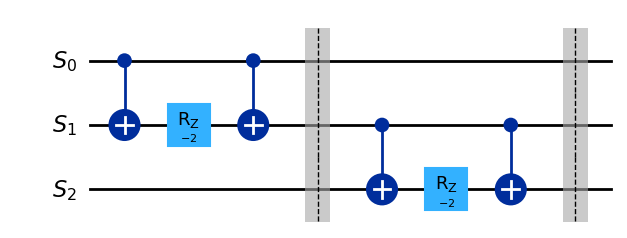

In [55]:
ExpH1(1, 3).draw(output="mpl")

Circuit for $e^{-i t H_2}$

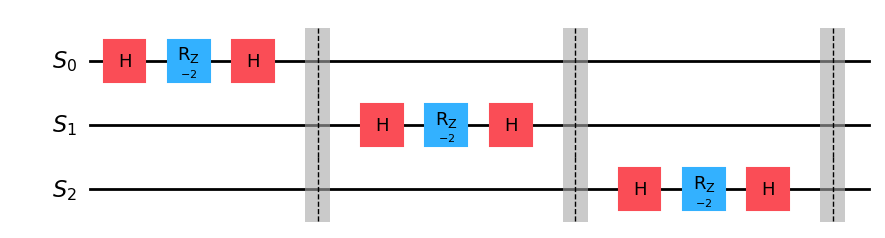

In [56]:
ExpH2(1, 1, 3).draw(output="mpl")

The full time evolution $e^{-i t H}$ in the second order Trotter expansion $e^{-i t H} = \left(e^{-it H_1/2} e^{-it H_2/2} \right)^2 + \mathcal{O}\left(2^3 \left(\frac{t}{2}\right)^2\right)$

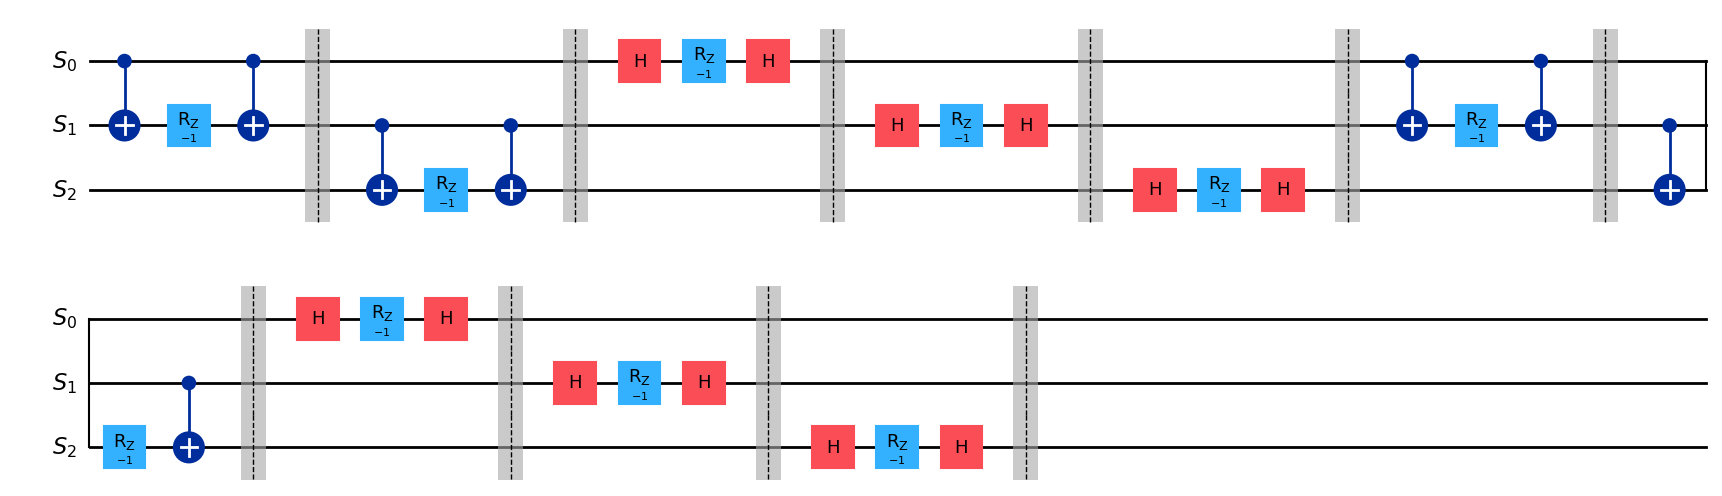

In [57]:
TrotterIsing(1, 1, 3, 2).draw(output="mpl")

In [149]:
IsingN5Test = TrotterIsing(0.1, 1, 3, 10)
res = np.round(Statevector(IsingN5Test).probabilities(), 3)
print(f"Statevector: {np.round(Statevector(IsingN5Test),3)}, \nProbabilities: {res}")

Statevector: [ 0.965+0.197j -0.011+0.098j -0.002+0.098j -0.01 -0.j    -0.011+0.098j
 -0.01 -0.j    -0.01 -0.j     0.   -0.001j], 
Probabilities: [0.971 0.01  0.01  0.    0.01  0.    0.    0.   ]


In [37]:
# Analytic Computation
import scipy

def AnalyticHamiltonian(h: float, N: int) -> np.array:
    """
    Implementation of the analytic Hamiltonian H

    Args:
        h (float): magnetic field magnitude
        N (int):   number of spins (qubits)
    
    Returns:
        np.array: Hamiltonian matrix as np.array object
    """

    # initialize Hamiltonian to zeros
    ham = np.zeros((2**N,2**N))
    
    # construct H1
    for i in range(N-1):
        if i == 0:
            curr = np.array([[1, 0], [0, -1]])
        else:
            curr = np.eye(2)
        for _ in range(1, i):
            curr = np.kron(curr, np.eye(2))
        if i > 0:
            curr = np.kron(curr, np.array([[1, 0], [0, -1]]))
        curr = np.kron(curr, np.array([[1, 0], [0, -1]]))
        for _ in range(i+2,N):
            curr = np.kron(curr, np.eye(2))

        ham += -curr
    
    # add H2 to it
    for i in range(N):
        if i==0:
            curr = np.array([[0, 1], [1, 0]])
        else:
            curr = np.eye(2)
        
        for _ in range(1,i):
            curr = np.kron(curr, np.eye(2))
        
        if i > 0:
            curr = np.kron(curr,  np.array([[0, 1], [1, 0]]))
        
        for _ in range(i+1, N):
            curr = np.kron(curr, np.eye(2))
        
        ham += -h*curr
    
    return ham

In [92]:
HN3 = AnalyticHamiltonian(1, 3)
init = np.zeros(2**3)
init[0] = 1
expH  = scipy.linalg.expm(-1j * HN3 * 0.1)
vec    = expH @ init
vec    = vec / vec[0] # global phase
cvec   = vec / np.linalg.norm(vec) # normalize
cvecprob = np.abs(cvec)**2
print(f"Hamiltonian: \n{HN3}\nInitial state: \n|000>={init}\nExp(-iHt)=\n{np.round(expH,3)}\nResulting state after t=0.5: {np.round(cvec,3)}")
print(f"Probabilities: {np.round(np.abs(cvec)**2,3)}")

Hamiltonian: 
[[-2. -1. -1.  0. -1.  0.  0.  0.]
 [-1.  0.  0. -1.  0. -1.  0.  0.]
 [-1.  0.  2. -1.  0.  0. -1.  0.]
 [ 0. -1. -1.  0.  0.  0.  0. -1.]
 [-1.  0.  0.  0.  0. -1. -1.  0.]
 [ 0. -1.  0.  0. -1.  2.  0. -1.]
 [ 0.  0. -1.  0. -1.  0.  0. -1.]
 [ 0.  0.  0. -1.  0. -1. -1. -2.]]
Initial state: 
|000>=[1. 0. 0. 0. 0. 0. 0. 0.]
Exp(-iHt)=
[[ 0.965+0.197j -0.01 +0.098j -0.   +0.098j -0.01 -0.j    -0.01 +0.098j
  -0.01 -0.j    -0.01 -0.j     0.   -0.001j]
 [-0.01 +0.098j  0.985-0.j    -0.01 +0.j     0.   +0.099j -0.01 -0.j
   0.01 +0.098j  0.   -0.001j -0.01 -0.j   ]
 [ 0.   +0.098j -0.01 +0.j     0.965-0.197j  0.01 +0.098j -0.01 +0.j
  -0.   -0.001j  0.01 +0.098j -0.01 -0.j   ]
 [-0.01 -0.j     0.   +0.099j  0.01 +0.098j  0.985-0.j     0.   -0.001j
  -0.01 +0.j    -0.01 -0.j    -0.01 +0.098j]
 [-0.01 +0.098j -0.01 -0.j    -0.01 +0.j     0.   -0.001j  0.985-0.j
   0.01 +0.098j  0.   +0.099j -0.01 -0.j   ]
 [-0.01 -0.j     0.01 +0.098j -0.   -0.001j -0.01 +0.j     0.01 +0.098

Define the Magnetization and Spin Projections of individual spins

In [232]:
def StateToSpin(probVec: np.array, numSpins: int) -> dict:
    """
    Transform statevector probabilities to spin configuration with probabilities
    
    Args:
        probVec (np.array): vector of probabilities for each basis element
        numSpins (int):     total number of spins on chain
    
    Returns:
        dict: dictionary in the form spin-configuration: probabilitiy, i.e. {[0,0,...,0]: 0.9, ...}
    """
    spinDict = {}
    for i, prob in enumerate(probVec):
        spinDict[tuple((i >> np.arange(numSpins))%2)] = prob
    
    return spinDict

def Magnetization(SpinDict: dict, numSpins: int) -> float:
    """
    Computes the mangetization (probability weighted sum of spins) for the Ising Model
    
    Args:
        SpinDict (dict):    dictionary that contains the spin configuration as a tuple as key and the corresponding probability as value
        numSpins (int):     total number of spins on chain
    
    Returns:
        float: magnetization
    """
    magn = 0
    for spins, prob in SpinDict.items():
        magn += prob*(numSpins - 2*sum(spins))
    
    return magn/numSpins

def ProbSpinUp(SpinDict: dict, SpinIndex: int) -> float:
    """
    Computes the probability that a given spin with index SpinIndex is in the up position (0)
    
    Args:
        SpinDict (dict):    dictionary that contains the spin configuration as a tuple as key and the corresponding probability as value
        numSpins (int):     total number of spins on chain
    
    Returns:
        float: probability that the spin with index SpinIndex has a positive projection along the z-axis, i.e. it isencoded by a 0
    """
    probUp = 0
    for spins, prob in SpinDict.items():
        if spins[SpinIndex] == 0:
            probUp += prob
    
    return probUp

In [93]:
Magnetization(StateToSpin(cvecprob, 3), 3)

np.float64(0.8877471655142127)

In [97]:
ProbSpinUp(StateToSpin(cvecprob, 3), 2)

np.float64(0.970592831293973)

Compute the magnetization as a function of time for various Trotterization parameters

In [181]:
from tqdm import tqdm
# find exact result
N = 3
h = 5
tmax = 4
tstep = 0.05
magn_exact = []
magn_1 = []
magn_10 = []
magn_50 = []
HN3 = AnalyticHamiltonian(h, N)
init = np.zeros(2**N)
init[0] = 1

for t in tqdm(np.arange(0, tmax, tstep)):
    expH  = scipy.linalg.expm(-1j * HN3 * t)
    vec    = expH @ init
    vec    = vec / vec[0] # global phase
    cvec   = vec / np.linalg.norm(vec) # normalize
    cvecprob = np.abs(cvec)**2
    spinDict_exact = StateToSpin(cvecprob, N)
    magn_exact.append([t, Magnetization(spinDict_exact, N)])

for t in tqdm(np.arange(0, tmax, tstep)):
    Ising1 = TrotterIsing(t, h, N, 1)
    res1 = Statevector(Ising1).probabilities()
    spinDict_1 = StateToSpin(res1, N)
    magn_1.append([t, Magnetization(spinDict_1, N)])

for t in tqdm(np.arange(0, tmax, tstep)):
    Ising10 = TrotterIsing(t, h, N, 10)
    res10 = Statevector(Ising10).probabilities()
    spinDict_10 = StateToSpin(res10, N)
    magn_10.append([t, Magnetization(spinDict_10, N)])

for t in tqdm(np.arange(0, tmax, tstep)):
    Ising50 = TrotterIsing(t, h, N, 50)
    res50 = Statevector(Ising50).probabilities()
    spinDict_50 = StateToSpin(res50, N)
    magn_50.append([t, Magnetization(spinDict_50, N)])


100%|██████████| 80/80 [00:01<00:00, 76.64it/s]


Text(0.5, 1.0, '1D Ising Model with $N=3$ Spins and $h=5J$')

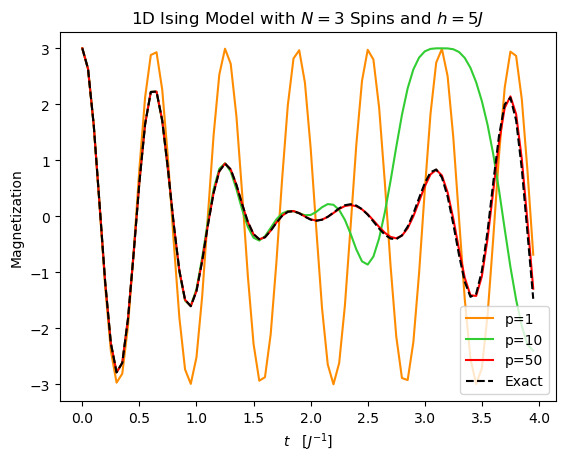

In [201]:
import matplotlib.pyplot as plt

plt.plot([x[0] for x in magn_1], [x[1] for x in magn_1], c="darkorange", ls="-", label="p=1")
plt.plot([x[0] for x in magn_10], [x[1] for x in magn_10], c="limegreen", ls="-", label="p=10")
plt.plot([x[0] for x in magn_50], [x[1] for x in magn_50], c="red", ls="-", label="p=50")
plt.plot([x[0] for x in magn_exact], [x[1] for x in magn_exact], c="k", ls="--", label="Exact")
plt.xlabel(r'$t$   $[J^{-1}]$')
plt.ylabel("Magnetization")
plt.legend(loc="lower right")
plt.title("1D Ising Model with $N=3$ Spins and $h=5J$")

Now let us consider the operator error

In [259]:
from tqdm import tqdm
# find exact result
N = 3
h = 5
tmax = 4
tstep = 0.05
error_1 = []
error_10 = []
error_50 = []
HN3 = AnalyticHamiltonian(h, N)
init = np.zeros(2**N)
init[0] = 1

for t in tqdm(np.arange(0, tmax, tstep)):
    expH  = scipy.linalg.expm(-1j * HN3 * t)
    IsingH1 = Operator(TrotterIsing(t, h, N, 1)).data
    error_1.append([t, np.linalg.svdvals(expH - IsingH1)[0]])

for t in tqdm(np.arange(0, tmax, tstep)):
    expH  = scipy.linalg.expm(-1j * HN3 * t)
    IsingH10 = Operator(TrotterIsing(t, h, N, 10)).data
    error_10.append([t,  np.linalg.svdvals(expH - IsingH10)[0]])

for t in tqdm(np.arange(0, tmax, tstep)):
    expH  = scipy.linalg.expm(-1j * HN3 * t)
    IsingH50 = Operator(TrotterIsing(t, h, N, 50)).data
    error_50.append([t, np.linalg.svdvals(expH - IsingH50)[0]])

100%|██████████| 80/80 [00:02<00:00, 30.62it/s]


Text(0.5, 1.0, '1D Ising Model with $N=3$ Spins and $h=5J$')

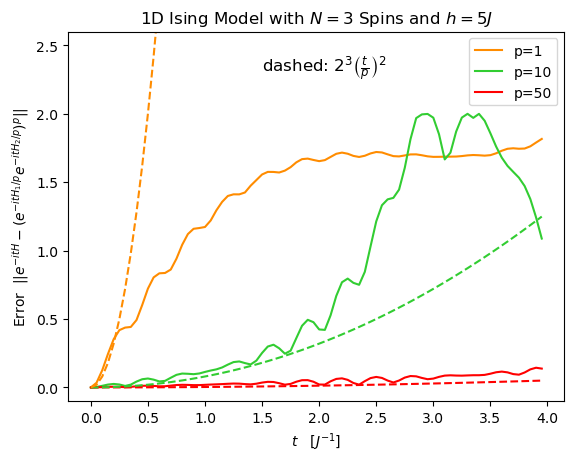

In [262]:
plt.plot([x[0] for x in error_1], [x[1] for x in error_1], c="darkorange", ls="-", label="p=1")
plt.plot([x[0] for x in error_10], [x[1] for x in error_10], c="limegreen", ls="-", label="p=10")
plt.plot([x[0] for x in error_50], [x[1] for x in error_50], c="red", ls="-", label="p=50")
plt.plot([x[0] for x in error_50], [8*(x[0]/50)**2 for x in error_50], c="red", ls="--")
plt.plot([x[0] for x in error_10], [2**3 *(x[0]/10)**2 for x in error_10], c="limegreen", ls="--")
plt.plot([x[0] for x in error_1], [2**3 *(x[0]/1)**2 for x in error_1], c="darkorange", ls="--")
plt.ylim(-0.1,2.6)
plt.xlabel('$t$   $[J^{-1}]$')
plt.ylabel("Error  $||e^{-it H} - (e^{-it H_1/p}e^{-it H_2/p})^p||$")
plt.text(1.5, 2.3, r'dashed: $2^3 \left( \frac{t}{p} \right)^2$', fontsize='large')
plt.legend(loc="upper right")
plt.title("1D Ising Model with $N=3$ Spins and $h=5J$")

## N=10
Now let us do the same for $N=10$ spins with the same parameters

In [229]:
from tqdm import tqdm
# find exact result
N = 10
h = 5
tmax = 4
tstep = 0.05
magn_exact = []
magn_1 = []
magn_10 = []
magn_50 = []
HN3 = AnalyticHamiltonian(h, N)
init = np.zeros(2**N)
init[0] = 1

for t in tqdm(np.arange(0, tmax, tstep)):
    expH  = scipy.linalg.expm(-1j * HN3 * t)
    vec    = expH @ init
    vec    = vec / vec[0] # global phase
    cvec   = vec / np.linalg.norm(vec) # normalize
    cvecprob = np.abs(cvec)**2
    spinDict_exact = StateToSpin(cvecprob, N)
    magn_exact.append([t, Magnetization(spinDict_exact, N)])

for t in tqdm(np.arange(0, tmax, tstep)):
    Ising1 = TrotterIsing(t, h, N, 1)
    res1 = Statevector(Ising1).probabilities()
    spinDict_1 = StateToSpin(res1, N)
    magn_1.append([t, Magnetization(spinDict_1, N)])

for t in tqdm(np.arange(0, tmax, tstep)):
    Ising10 = TrotterIsing(t, h, N, 10)
    res10 = Statevector(Ising10).probabilities()
    spinDict_10 = StateToSpin(res10, N)
    magn_10.append([t, Magnetization(spinDict_10, N)])

for t in tqdm(np.arange(0, tmax, tstep)):
    Ising50 = TrotterIsing(t, h, N, 50)
    res50 = Statevector(Ising50).probabilities()
    spinDict_50 = StateToSpin(res50, N)
    magn_50.append([t, Magnetization(spinDict_50, N)])

100%|██████████| 80/80 [00:04<00:00, 16.73it/s]


Text(0.5, 1.0, '1D Ising Model with $N=10$ Spins and $h=5J$')

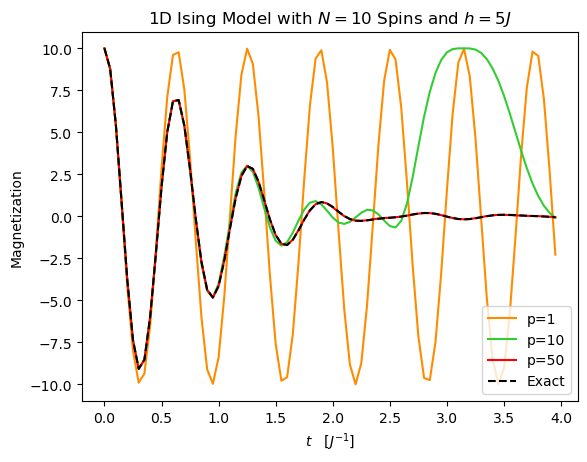

In [230]:
plt.plot([x[0] for x in magn_1], [x[1] for x in magn_1], c="darkorange", ls="-", label="p=1")
plt.plot([x[0] for x in magn_10], [x[1] for x in magn_10], c="limegreen", ls="-", label="p=10")
plt.plot([x[0] for x in magn_50], [x[1] for x in magn_50], c="red", ls="-", label="p=50")
plt.plot([x[0] for x in magn_exact], [x[1] for x in magn_exact], c="k", ls="--", label="Exact")
plt.xlabel(r'$t$   $[J^{-1}]$')
plt.ylabel("Magnetization")
plt.legend(loc="lower right")
plt.title("1D Ising Model with $N=10$ Spins and $h=5J$")

In [231]:
from tqdm import tqdm
# find exact result
N = 10
h = 5
tmax = 4
tstep = 0.05
error_1 = []
error_10 = []
error_50 = []
HN3 = AnalyticHamiltonian(h, N)
init = np.zeros(2**N)
init[0] = 1

for t in tqdm(np.arange(0, tmax, tstep)):
    expH  = scipy.linalg.expm(-1j * HN3 * t)
    IsingH1 = Operator(TrotterIsing(t, h, N, 1)).data
    error_1.append([t, np.linalg.svdvals(expH - IsingH1)[0]])

for t in tqdm(np.arange(0, tmax, tstep)):
    expH  = scipy.linalg.expm(-1j * HN3 * t)
    IsingH10 = Operator(TrotterIsing(t, h, N, 10)).data
    error_10.append([t,  np.linalg.svdvals(expH - IsingH10)[0]])

for t in tqdm(np.arange(0, tmax, tstep)):
    expH  = scipy.linalg.expm(-1j * HN3 * t)
    IsingH50 = Operator(TrotterIsing(t, h, N, 50)).data
    error_50.append([t, np.linalg.svdvals(expH - IsingH50)[0]])

100%|██████████| 80/80 [30:37<00:00, 22.97s/it]


Text(0.5, 1.0, '1D Ising Model with $N=3$ Spins and $h=5J$')

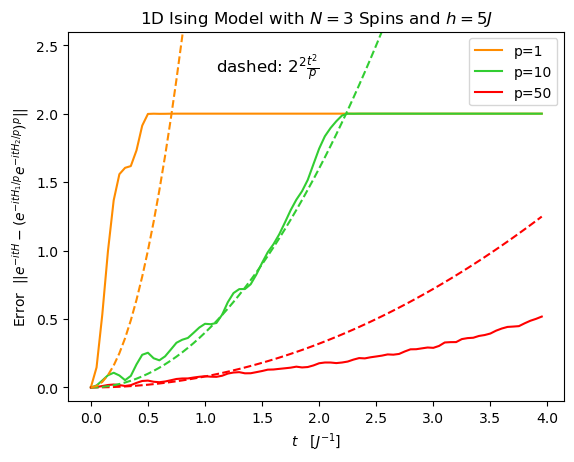

In [258]:
plt.plot([x[0] for x in error_1], [x[1] for x in error_1], c="darkorange", ls="-", label="p=1")
plt.plot([x[0] for x in error_10], [x[1] for x in error_10], c="limegreen", ls="-", label="p=10")
plt.plot([x[0] for x in error_50], [x[1] for x in error_50], c="red", ls="-", label="p=50")
plt.plot([x[0] for x in error_50], [4*(x[0])**2/50 for x in error_50], c="red", ls="--")
plt.plot([x[0] for x in error_10], [4*(x[0])**2/10 for x in error_10], c="limegreen", ls="--")
plt.plot([x[0] for x in error_1], [4*(x[0]/1)**2 for x in error_1], c="darkorange", ls="--")
plt.ylim(-0.1,2.6)
plt.xlabel('$t$   $[J^{-1}]$')
plt.ylabel("Error  $||e^{-it H} - (e^{-it H_1/p}e^{-it H_2/p})^p||$")
plt.text(1.1, 2.3, r'dashed: $2^2 \frac{t^2}{p}$', fontsize='large')
plt.legend(loc="upper right")
plt.title("1D Ising Model with $N=3$ Spins and $h=5J$")